# Computer Vision and Image Processing - Take Home Assignment 02

---

| Field | Details |
|-------|---------|
| **Registration Number** | `EG/2020/4113` |
| **Name** | Perera K.R.D |
| **Repository** | [📁 GitHub Repository](https://github.com/PereraKRD/Computer_Vision_and_Image_Processing_Take_Home_02.git) |

---

In [82]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from skimage import filters
from collections import deque

## TASK 01 - Implement and test Otsu’s algorithm with an image.

In [83]:
def generate_synthetic_image(h=180, w=280):
    img = np.zeros((h, w), dtype=np.uint8)

    cv2.rectangle(img, (30, 30), (100, 100), color=120, thickness=-1)
    cv2.ellipse(img, center=(200, 120), axes=(40, 20), angle=0, startAngle=0, endAngle=360, color=220, thickness=-1)

    return img

In [84]:
def inject_gaussian_noise(img, mean=0, sigma=15):
    gaussian = np.random.normal(mean, sigma, img.shape)
    noisy = img + gaussian
    noisy_clipped = np.clip(noisy, 0, 255).astype(np.uint8)
    return noisy_clipped

In [85]:
def perform_otsu(image):
    _, th_opencv = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    th_skimage = filters.threshold_otsu(image)
    binary_sk = (image > th_skimage).astype(np.uint8) * 255
    return th_opencv, binary_sk, th_skimage

In [86]:
def visualize_all(img_orig, img_noisy, otsu_cv, otsu_sk, threshold_val):
    plt.figure(figsize=(14, 10))

    plt.subplot(2, 2, 1)
    plt.imshow(img_orig, cmap='gray')
    plt.title("New Synthetic Image")
    plt.axis('off')

    plt.subplot(2, 2, 2)
    plt.imshow(img_noisy, cmap='gray')
    plt.title("With Gaussian Noise")
    plt.axis('off')

    plt.subplot(2, 2, 3)
    plt.imshow(otsu_cv, cmap='gray')
    plt.title("Otsu (OpenCV)")
    plt.axis('off')

    plt.subplot(2, 2, 4)
    plt.imshow(otsu_sk, cmap='gray')
    plt.title("Otsu (skimage)")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

In [87]:
def save_results(img1, img2, otsu1, otsu2):
    output_path = os.path.join("..", "results", "task_01_alt")
    os.makedirs(output_path, exist_ok=True)

    cv2.imwrite(os.path.join(output_path, "01_synthetic.jpg"), img1)
    cv2.imwrite(os.path.join(output_path, "02_noisy.jpg"), img2)
    cv2.imwrite(os.path.join(output_path, "03_otsu_cv.jpg"), otsu1)
    cv2.imwrite(os.path.join(output_path, "04_otsu_sk.jpg"), otsu2)

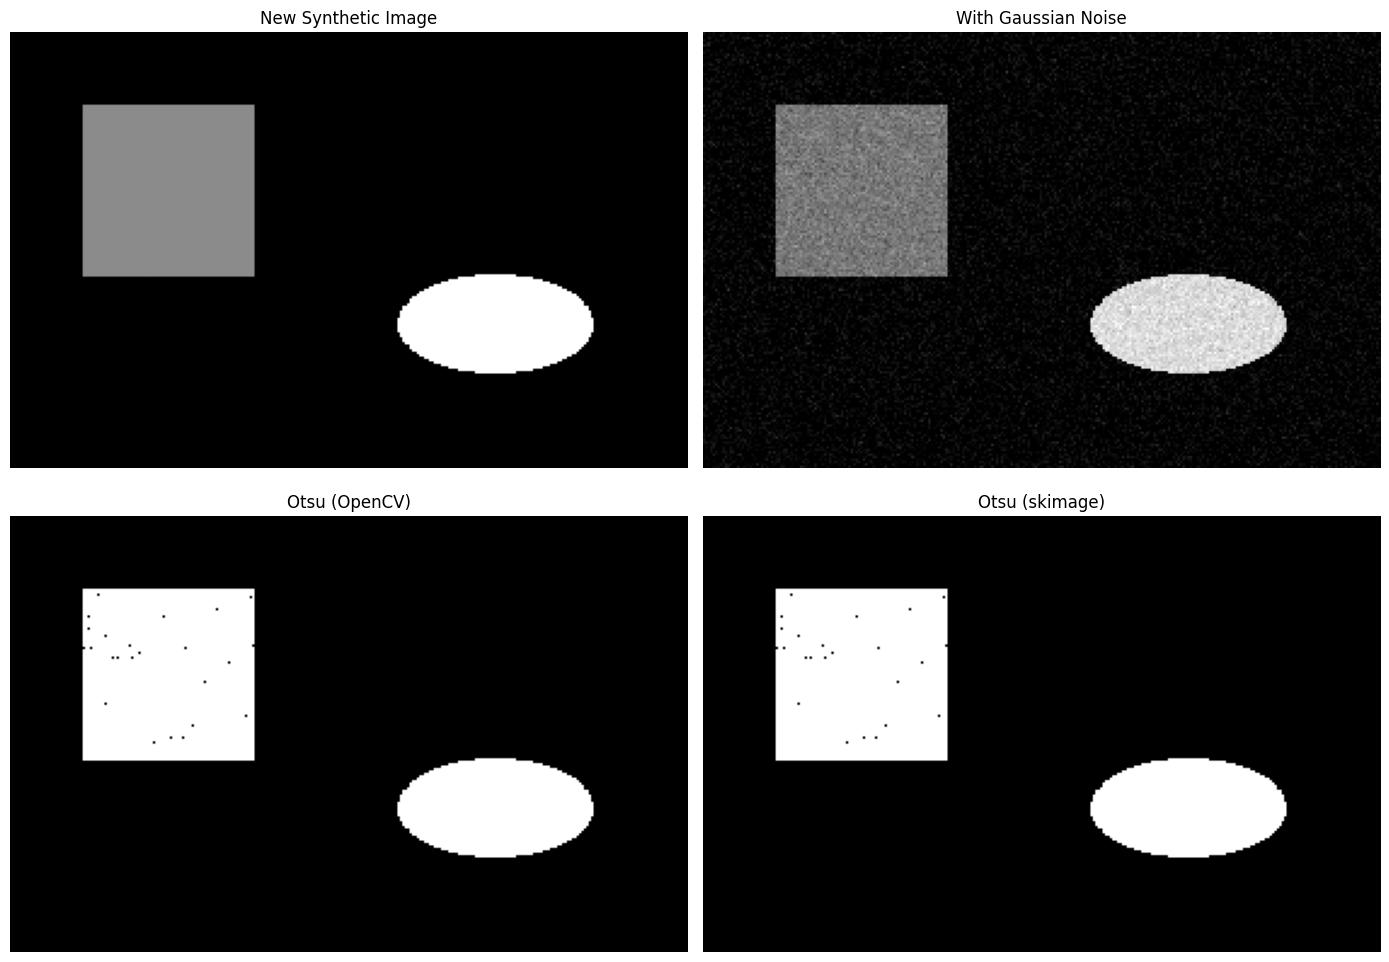

In [88]:
base_img = generate_synthetic_image()
noisy_img = inject_gaussian_noise(base_img)
otsu_result_cv, otsu_result_sk, otsu_thresh = perform_otsu(noisy_img)

visualize_all(base_img, noisy_img, otsu_result_cv, otsu_result_sk, otsu_thresh)
save_results(base_img, noisy_img, otsu_result_cv, otsu_result_sk)

## TASK 02 - Implement a region-growing technique for image segmentation

In [89]:
# Load grayscale image
image_path = os.path.join("..", "images", "task_02", "image.jpg")
gray_img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

if gray_img is None:
    raise FileNotFoundError(f"Image not found at {image_path}")

img_h, img_w = gray_img.shape
print(f"Loaded Image: {img_w} x {img_h}")

Loaded Image: 4256 x 2832


In [90]:
def grow_region(image, seeds, threshold=20, use_8connectivity=True):
    height, width = image.shape

    region = np.zeros_like(image, dtype=np.uint8)
    visited = np.zeros_like(image, dtype=np.uint8)

    from collections import deque
    queue = deque(seeds)

    for y, x in seeds:
        visited[y, x] = 1
        region[y, x] = 255

    seed_values = [int(image[y, x]) for y, x in seeds]

    if use_8connectivity:
        neighbors = [(-1, -1), (-1, 0), (-1, 1),
                     (0, -1),          (0, 1),
                     (1, -1), (1, 0), (1, 1)]
    else:
        neighbors = [(-1, 0), (1, 0), (0, -1), (0, 1)]

    while queue:
        y, x = queue.popleft()
        for dy, dx in neighbors:
            ny, nx = y + dy, x + dx
            if 0 <= ny < height and 0 <= nx < width and not visited[ny, nx]:
                pixel_value = int(image[ny, nx])
                if any(abs(pixel_value - sv) <= threshold for sv in seed_values):
                    region[ny, nx] = 255
                    visited[ny, nx] = 1
                    queue.append((ny, nx))

    return region


In [91]:
seeds = [(843, 1348), (281, 1174), (1139, 1085)]

result_mask = grow_region(gray_img, seeds=seeds, threshold=25, use_8connectivity=True)

for i, s in enumerate(seeds):
    print(f"Seed {i+1} at {s} → value: {gray_img[s]}")

Seed 1 at (843, 1348) → value: 244
Seed 2 at (281, 1174) → value: 246
Seed 3 at (1139, 1085) → value: 241


In [92]:
def visualize_region_growing(img, mask, seed_coords):
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    for sy, sx in seed_coords:
        plt.scatter(sx, sy, c='red', s=60, marker='x', linewidths=2)
    plt.title("Original Image with Seeds")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.title("Region Growing Output")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

In [93]:
def save_result_image(mask, output_dir, filename="region_grown_mask.jpg"):
    os.makedirs(output_dir, exist_ok=True)
    cv2.imwrite(os.path.join(output_dir, filename), mask)

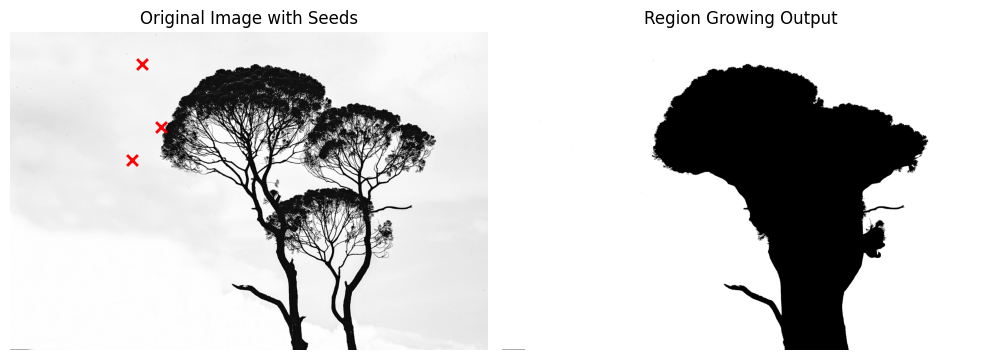

In [94]:
visualize_region_growing(gray_img, result_mask, seeds)
save_result_image(result_mask, output_dir=os.path.join("..", "results", "task_02_alt"))